In [ ]:
import torch
import os
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

task 1: define tokenization and text processing steps using GPT2Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# path to folder with fairy tales
folder_path = '/content/drive/MyDrive/fairy_tales'

#load dataset
fairy_tales = []
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        try:
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                fairy_tales.append(file.read())
        except UnicodeDecodeError:
            with open(os.path.join(folder_path, filename), 'r', encoding='latin-1') as file:
                fairy_tales.append(file.read())

# clean text
import re

def clean_text(text):
    text = re.sub(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', ' ', text)
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # keep important punctuations
    text = re.sub(r' [.] ', '. ', text)
    text = re.sub(r' [, ] ', ', ', text)
    text = re.sub(r' [?] ', '?' , text)
    text = re.sub(r' [! ] ', '! ', text)
    text = re.sub(r' ["]+ ', '"', text)
    text = text.strip() #remove leading and trailing whitespaces
    return text

cleaned_fairy_tales = [clean_text(tale) for tale in fairy_tales]

# split dataset into training and test sets
train_texts, test_texts = train_test_split(cleaned_fairy_tales, test_size=0.2, random_state=42)

# initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token # set padding token to end of sequence token

# tokenize and pad/truncate fairy tales
max_length = 512 # 1024 is the maximum length supported by GPT2, halving for mem constraints
tokenized_fairy_tales = [tokenizer(tale, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt') for tale in cleaned_fairy_tales]
input_ids = [t['input_ids'].squeeze(0) for t in tokenized_fairy_tales]
attention_masks = [t['attention_mask'].squeeze(0) for t in tokenized_fairy_tales]

# pad sequences
padded_input_ids = rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.eos_token_id)
padded_attention_masks = rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


task 2: describe training strategy and method for calculating loss during training.

below, I have defined a class to load and prepare the texts in the dataset. I use `DataLoader`s to feed batches of data to the model during training + eval.

shown later, this model uses the standard cross-entropy loss function for language modeling. then the loss is averaged over all the tokens in the batch to get a single loss value for the batch.

In [27]:
class FairyTalesDataset(torch.utils.data.Dataset):
   def __init__(self, texts, tokenizer, max_len):
       self.texts = texts
       self.tokenizer = tokenizer
       self.max_len = max_len

   def __len__(self):
       return len(self.texts)

   def __getitem__(self, idx):
       text = self.texts[idx]

       encoding = self.tokenizer.encode_plus(
           text,
           add_special_tokens=True,
           max_length=self.max_len,
           return_token_type_ids=False,
           padding='max_length',
           return_attention_mask=True,
           return_tensors='pt',
           truncation=True
       )

       return {
           'input_ids': encoding['input_ids'].flatten(),
           'attention_mask': encoding['attention_mask'].flatten(),
       }

# create datasets
train_dataset = FairyTalesDataset(train_texts, tokenizer, max_length)
test_dataset = FairyTalesDataset(test_texts, tokenizer, max_length)

# data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

task 3: define GPT-based model. describe any additional fine-tuning layers added.

In [31]:
# initialize model
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)
# enable gradient checkpointing
model.gradient_checkpointing_enable()
model.config.use_cache = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay=0.01)
num_epochs = 15
train_losses = []
val_losses = []

def train_model(model, optimizer, train_loader):
    model.train()
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs[0]
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        del input_ids, attention_mask, outputs, loss  # free up memory

    return total_loss / len(train_loader)

def evaluate_model(model, test_loader):
    model.eval()
    total_acc = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            total_acc += loss.item()

    return total_acc / len(test_loader)

task 4: fine-tune model and report loss curve

** I was able to get lower training loss and validation loss scores before I cleaned the text, but it took significantly longer to train and the story generator was only outputting special characters like ""!##!@!"@#. after adding the clean_text function above, the scores became higher, but maintaining similar curves, with much better story generation.



Epoch 1 / 15
Epoch 1, Train Loss: 3.890858044107276, Val Loss: 3.6007919992719377
Epoch 2 / 15
Epoch 2, Train Loss: 3.7152555534638556, Val Loss: 3.548875229699271
Epoch 3 / 15
Epoch 3, Train Loss: 3.6511400578969933, Val Loss: 3.5171951225825717
Epoch 4 / 15
Epoch 4, Train Loss: 3.6153777909566123, Val Loss: 3.495133649735224
Epoch 5 / 15
Epoch 5, Train Loss: 3.5857606680996446, Val Loss: 3.4776145276569186
Epoch 6 / 15
Epoch 6, Train Loss: 3.5542492493089424, Val Loss: 3.465193124044509
Epoch 7 / 15
Epoch 7, Train Loss: 3.534764783928193, Val Loss: 3.45488250823248
Epoch 8 / 15
Epoch 8, Train Loss: 3.5171031262501176, Val Loss: 3.444843950725737
Epoch 9 / 15
Epoch 9, Train Loss: 3.4999357447566757, Val Loss: 3.437725407736642
Epoch 10 / 15
Epoch 10, Train Loss: 3.4837687130433967, Val Loss: 3.431303626015073
Epoch 11 / 15
Epoch 11, Train Loss: 3.4689995007342604, Val Loss: 3.425246034349714
Epoch 12 / 15
Epoch 12, Train Loss: 3.4538974589612113, Val Loss: 3.421201535633632
Epoch 13 /

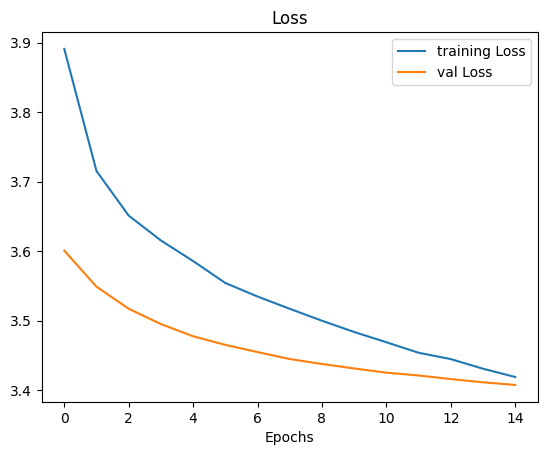

In [32]:
# training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} / {num_epochs}')
    train_loss = train_model(model, optimizer, train_loader)
    val_loss = evaluate_model(model, test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

plt.plot(train_losses, label='training Loss')
plt.plot(val_losses, label='val Loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()
plt.show()

task 5: use trained model to generate short story using prompt: `prompt = 'Once upon a time in a faraway land, there was a young prince who'`

In [34]:
model.eval()

prompt = "Once upon a time in a faraway land, there was a young prince who"

input_ids = tokenizer.encode(prompt, add_special_tokens=False, return_tensors='pt').to(device)
attention_mask = torch.ones_like(input_ids).to(device)

output = model.generate(
    input_ids=input_ids,
    max_length=200,
    num_beams=10,
    attention_mask=attention_mask,
    labels=input_ids,
    top_k = 50,
    top_p = 0.95,
    repetition_penalty=1.2,
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    do_sample=True,
    temperature=0.7
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
generated_text = generated_text[: generated_text.find(tokenizer.eos_token)]

print(generated_text)

Once upon a time in a faraway land, there was a young prince who had just returned from a long journey and he was about to embark on a journey when he heard a voice say to him 'I have come to the land of the dead and I am going to take you with me' The prince was very frightened and said to himself 'What is the matter with you and how can I help you if I do not know what to do for you' Then the voice said 'You must go and find a way out of here or you will be killed' So the prince went and found a cave in which he dug a hole and as he went through it he came to an old man who was lying on the ground with his hands tied behind his back and his face covered with blood When he looked up at him he saw that he had been cut off from the rest of his family and that his father was dead There was no one to help him and so he set out to find hi
